## Generate trench stats figures.

Generate figures for trench stats.

In [1]:
from __future__ import print_function

import pygplates
import matplotlib.pyplot as plt
import numpy as np
import os.path
import glob
from scipy.signal import medfilt

import matplotlib as mpl
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.sans-serif'] = "arial"
mpl.rcParams['text.usetex'] == True


#######################################################
# Define Input files
#######################################################

print(pygplates.__version__)

#model_dir = 'Global_Model_WD_Internal_Release_2019_v3'
model_dir = 'Global_1000-0_Model_2017'

if model_dir.startswith('Global_Model_WD_Internal_Release'):
    # Define the time snapshots
    min_time = 0
    max_time = 410
    
    rotation_base_filenames = [
        'Alps_Mesh_Rotations_2019_v2',
        'Andes_Flat_Slabs_Rotations_2019_v2',
        'Andes_Rotations_2019_v2',
        'Australia_Antarctica_Mesh_Rotations_2019_v2',
        'Australia_North_Zealandia_Rotations_2019_v2',
        'Eurasia_Arabia_Mesh_Rotations_2019_v2',
        'Global_250-0Ma_Rotations_2019_v2',
        'Global_410-250Ma_Rotations_2019_v2',
        'North_America_Flat_Slabs_Rotations_2019_v2',
        'North_America_Mesh_Rotations_2019_v2',
        'North_China_Mesh_Rotations_2019_v2',
        'Southeast_Asia_Rotations_2019_v2',
        'South_Atlantic_Rotations_2019_v2',
        'South_China_DeformingModel_xianzhi',
    ]
    
    # Models to plot.
    model_infos = [
    ]
elif model_dir == 'Global_1000-0_Model_2017':
    # Define the time snapshots
    min_time = 0
    max_time = 1000
    
    rotation_base_filenames = ['1000_0_rotfile_Merdith_et_al']

    # Models to plot.
    model_infos = [
        (None, 'red', 'Not Optimized'),
        #('svn1628_run10', 'blue', 'svn1628 run10 (TM=1;1, NR=1, PV=1 | TM[-30,30], NR[0.08,0.2], PV[0,60])'),
        #('svn1628_run12', 'green', 'svn1628 run12 (TM=1;0.5, NR=1, PV=1 | TM[-30,30], NR[0.08,0.2], PV[0,60])'),
        #('svn1628_run13', 'darkorange', 'svn1628 run13 (TM=1;1, NR=0.5, PV=1 | TM[-30,30], NR[0.08,0.2], PV[0,60])'),
        #('svn1628_run14', 'blue', 'run14 ref:OPT ang:30'),
        #('svn1628_run15', 'green', 'svn1628 run15'),
        #('svn1628_run16', 'darkorange', 'run16 ref:NNR ang:180'),
        #('svn1628_run17', 'darkorange', 'svn1628 run17 trench cost: 10 x advancing samples'),
        ('svn1683_run18', 'blue', 'svn1683 run18'),
        ('svn1683_run19', 'green', 'svn1683 run19'),
        ('svn1683_run20', 'brown', 'svn1683 run20'),
        ('svn1683_run21', 'darkorange', 'svn1683 run21'),
    ]
else:
    # Define the time snapshots
    min_time = 0
    max_time = 410
    
    rotation_base_filenames = []
    
    # Models to plot.
    model_infos = []


time_step = 5

threshold_sampling_distance_radians = np.radians(1.0)
    
input_dir = '../data/{0}'.format(model_dir)
output_dir = './{0}'.format(model_dir)

original_rotation_filenames = [os.path.join(input_dir, rotation_base_filename + '.rot')
        for rotation_base_filename in rotation_base_filenames]


#
# Topologies to be used
#
if model_dir == 'Global_1000-0_Model_2017':
    # Starting at SVN rev 1624 there are other GPML files that we don't need to include.
    topology_base_filenames = [
        '250-0_plate_boundaries_Merdith_et_al.gpml',
        '410-250_plate_boundaries_Merdith_et_al.gpml',
        '1000-410-Convergence_Merdith_et_al.gpml',
        '1000-410-Divergence_Merdith_et_al.gpml',
        '1000-410-Topologies_Merdith_et_al.gpml',
        '1000-410-Transforms_Merdith_et_al.gpml',
        'TopologyBuildingBlocks_Merdith_et_al.gpml',
    ]
    topology_filenames = [os.path.join(input_dir, topology_base_filename)
            for topology_base_filename in topology_base_filenames]
else:
    topology_filenames = glob.glob(os.path.join(input_dir, '*.gpml'))

topology_features = [pygplates.FeatureCollection(topology_filename)
                    for topology_filename in topology_filenames]

# Typically the achor plate id should be 0
anchor_plate_id = 0

# Increment for each figure saved in a session (changes filename).
# Useful when changing a trench stat to plot, then plotting, and repeating.
save_figure_count = 0

2.2.0.28


In [2]:
import sys
sys.path.insert(1, '..')
import subduction_convergence_for_absolute_plate_motion as scap


# A list of times to sample the motion path.
times = range(min_time+time_step, max_time+1, time_step)

tm_stats_models = []

#
# Generate the trench statistics for each model (most of the number crunching time is spent here).
#
for model_info in model_infos:
    model_name, _, _ = model_info
    
    if model_name is None:
        # Un-optimised rotation model.
        rotation_model = pygplates.RotationModel(original_rotation_filenames)
    else:
        # Optimised rotation model.
        optimised_rotation_filenames = [
                os.path.join(input_dir, 'optimisation', rotation_base_filename + '_{0}.rot'.format(model_name))
                    for rotation_base_filename in rotation_base_filenames]
        rotation_model = pygplates.RotationModel(optimised_rotation_filenames)
        
    tm_stats_model = []
    
    for time in times:
        # Resolve trench features
        resolved_trench_features = scap.resolve_subduction_zones(
                rotation_model,
                topology_features,
                time)

        # Calculate trench segment stats.
        #
        # Note that migration velocities are calculated from 'time' to 'time - time_step'.
        tm_stats = scap.subduction_absolute_motion(rotation_model,
                                                   resolved_trench_features,
                                                   threshold_sampling_distance_radians,
                                                   time,
                                                   velocity_delta_time=time_step)
        
        tm_stats_model.append(tm_stats)
    
    tm_stats_models.append(tm_stats_model)


..\subduction_convergence_for_absolute_plate_motion.py:276: RuntimeWarning: Sub-segment polyline coincides with a point in feature "Shirshov Ridge Subduction".

  warnings.warn('Sub-segment polyline coincides with a point in feature "{0}".\n'.format(shared_sub_segment_feature.get_name()), RuntimeWarning)
..\subduction_convergence_for_absolute_plate_motion.py:243: RuntimeWarning: Unknown subduction polarity in feature "Kazak SZ".

  warnings.warn('Unknown subduction polarity in feature "{0}".\n'.format(shared_sub_segment_feature.get_name()), RuntimeWarning)
..\subduction_convergence_for_absolute_plate_motion.py:243: RuntimeWarning: Unknown subduction polarity in feature "Early onset Terra Australis?".

  warnings.warn('Unknown subduction polarity in feature "{0}".\n'.format(shared_sub_segment_feature.get_name()), RuntimeWarning)
..\subduction_convergence_for_absolute_plate_motion.py:243: RuntimeWarning: Unknown subduction polarity in feature "Siberia-ocean SZ".

  warnings.warn('Unknown

In [3]:
#
# Get the specific trench stat we'd like to plot.
#
trench_plot_models = []

for tm_stats_model in tm_stats_models:
    trench_plot_model = []
    
    for index, time in enumerate(times):
        tm_stats = tm_stats_model[index]

        # Process tm_stats to extract values for use in cost function
        trench_lon = []
        trench_lat = []
        trench_vel = []
        trench_obl = []
        trench_plate_id = []

        for i in range(0, len(tm_stats)):

            trench_lon.append(tm_stats[i][0])
            trench_lat.append(tm_stats[i][1])
            trench_vel.append(tm_stats[i][2])
            trench_obl.append(tm_stats[i][3])
            trench_plate_id.append(tm_stats[i][6])

        trench_lon = np.array(trench_lon)
        trench_lat = np.array(trench_lat)
        trench_vel = np.array(trench_vel)
        trench_obl = np.array(trench_obl)
        trench_plate_id = np.array(trench_plate_id)

        # Scale velocities from cm/yr to mm/yr.
        # Note that mm/yr is same as km/Myr.
        trench_vel = trench_vel * 10

        # Calculate trench orthogonal velocity
        tm_vel_orth = np.abs(trench_vel) * -np.cos(np.radians(trench_obl))
        tm_abs_vel_orth = np.abs(tm_vel_orth)

        # Mean of trench orthogonal velocity.
        tm_mean_vel_orth = np.sum(tm_vel_orth) / len(tm_vel_orth)

        # Mean of absolute trench orthogonal velocity.
        tm_mean_abs_vel_orth = np.sum(tm_abs_vel_orth) / len(tm_vel_orth)

        trench_numTotal = len(tm_vel_orth)
        trench_numRetreating = len(np.where(tm_vel_orth > 0)[0])
        trench_numAdvancing = len(tm_vel_orth) - trench_numRetreating
        trench_percent_retreat = round((np.float(trench_numRetreating) / np.float(trench_numTotal)) * 100, 2)
        trench_percent_advance = 100. - trench_percent_retreat
        trench_numOver30 = len(np.where(tm_vel_orth > 30)[0])
        trench_numLessNeg30 = len(np.where(tm_vel_orth < -30)[0])
        
        #
        # Attempt to discover which trench plate ID has the highest mean orthogonal velocity.
        # It's possible to find and plot the plate ID but it's easier to visualise the velocities in GPlates.
        #
        #max_plate_id = 0
        #max_per_plate_tm_abs_vel_orth = 0.0
        #for plate_id in np.unique(trench_plate_id):
        #    per_plate_tm_abs_vel_orth = np.mean(tm_abs_vel_orth[np.where(trench_plate_id == plate_id)])
        #    if per_plate_tm_abs_vel_orth > max_per_plate_tm_abs_vel_orth:
        #        max_per_plate_tm_abs_vel_orth = per_plate_tm_abs_vel_orth
        #        max_plate_id = plate_id
        #
        #trench_plot = plate_id; trench_plot_label = 'test'
        
        #trench_plot = 16.0 * np.mean(np.abs(np.where(tm_vel_orth > 0, 0.1 * tm_vel_orth, tm_vel_orth))); trench_plot_label = 'test'
        
        trench_plot = (tm_mean_abs_vel_orth + np.std(tm_vel_orth)) * 3; trench_plot_label = 'Original trench migration cost'
        #trench_plot = (trench_percent_advance * 10 + tm_mean_abs_vel_orth * 15) / 2; trench_plot_label = 'Runs 7/8 trench migration cost'
        #trench_plot = np.median(tm_abs_vel_orth) + np.median(abs(tm_abs_vel_orth - np.median(tm_abs_vel_orth))); trench_plot_label = 'median + MAD absolute orthogonal velocity (mm/yr)'
        #trench_plot = np.median(tm_vel_orth) + np.median(abs(tm_vel_orth - np.median(tm_vel_orth))); trench_plot_label = 'median + MAD orthogonal velocity (mm/yr)'
        #trench_plot = np.median(tm_abs_vel_orth) + np.median(abs(tm_vel_orth - np.median(tm_vel_orth))); trench_plot_label = 'median absolute orthogonal velocity + MAD orthogonal velocity (mm/yr)'
        #trench_plot = tm_mean_abs_vel_orth + np.median(abs(tm_vel_orth - np.median(tm_vel_orth))); trench_plot_label = 'mean absolute orthogonal velocity + MAD orthogonal velocity (mm/yr)'
        #trench_plot = trench_numTotal; trench_plot_label = 'Num trench samples'
        #trench_plot = trench_numAdvancing; trench_plot_label = 'Num trench samples advancing'
        #trench_plot = trench_percent_advance; trench_plot_label = 'Percent trench advance'
        #trench_plot = np.sum(trench_vel) / len(tm_vel_orth); trench_plot_label = 'Mean velocity (mm/yr)'
        #trench_plot = np.sum(abs(trench_vel)) / len(tm_vel_orth); trench_plot_label = 'Mean absolute velocity (mm/yr)'
        #trench_plot = np.min(tm_vel_orth); trench_plot_label = 'Min orthogonal velocity (mm/yr)'
        #trench_plot = np.max(tm_vel_orth); trench_plot_label = 'Max orthogonal velocity (mm/yr)'
        #trench_plot = tm_mean_vel_orth; trench_plot_label = 'Mean orthogonal velocity (mm/yr)'
        #trench_plot = tm_mean_abs_vel_orth; trench_plot_label = 'Mean absolute orthogonal velocity (mm/yr)'
        #trench_plot = np.std(tm_vel_orth); trench_plot_label = 'Std. dev. orthogonal velocity (mm/yr)'
        #trench_plot = np.std(tm_abs_vel_orth); trench_plot_label = 'Std. dev. absolute orthogonal velocity (mm/yr)'
        #trench_plot = np.median(tm_vel_orth); trench_plot_label = 'Median orthogonal velocity (mm/yr)'
        #trench_plot = np.median(tm_abs_vel_orth); trench_plot_label = 'Median absolute orthogonal velocity (mm/yr)'
        #trench_plot = np.median(abs(tm_vel_orth - np.median(tm_vel_orth))); trench_plot_label = 'MAD orthogonal velocity (mm/yr)'
        #trench_plot = np.median(abs(tm_abs_vel_orth - np.median(tm_abs_vel_orth))); trench_plot_label = 'MAD absolute orthogonal velocity (mm/yr)'
        
        trench_plot_model.append(trench_plot)
    
    trench_plot_models.append(trench_plot_model)


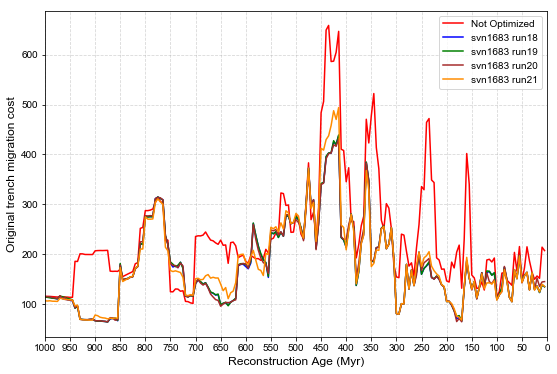

In [4]:
def plot_trench_stats(medfilt_kernel_sizes):
    
    global save_figure_count
    save_figure_count += 1
    
    for medfilt_kernel_size in medfilt_kernel_sizes:
        
        fig = plt.figure(figsize=(9,6))

        for model_index in range(len(model_infos)):
            trench_plot_model = trench_plot_models[model_index]
            
            _, color, label = model_infos[model_index]
            
            # Trench stats.
            plt.plot(
                times,
                medfilt(trench_plot_model, medfilt_kernel_size),
                color,
                label=label)

        plt.xlim([min(times), max(times)])
        #plt.ylim([4000, 4500])
        plt.xticks(np.arange(min_time, max_time+1, 50))
        #plt.yticks(np.arange(-50, 50+1, 5))
        plt.ylabel(trench_plot_label, fontsize=12)
        plt.xlabel('Reconstruction Age (Myr)', fontsize=12)
        plt.grid(linestyle='--',alpha=0.5)
        plt.gca().invert_xaxis() # Time should go from left to right.

        plt.legend(fontsize=10)

        plt.savefig(
            os.path.join(model_dir, 'trench_stats_%d_%dMy.pdf' % (save_figure_count, medfilt_kernel_size)),
            format='pdf',
            dpi=600)

        plt.show()


#medfilt_kernel_sizes = [1, 5, 11]
medfilt_kernel_sizes = [1]

plot_trench_stats(medfilt_kernel_sizes)